# Изучение поведения пользователей мобильного приложения стартапа по продаже продуктов питания

**Цель:** изучить воронку продаж, узнать как пользователи доходят до покупки и проанализировать результаты A/A/B эксперимента по изменению шрифтов в приложении

**План исследования**
1. Подготовка данных к анализу
2. Изучение и проверка данных
- Сколько всего событий в логе
- Сколько всего пользователей в логе
- Сколько в среднем событий приходится на пользователя
- Определить период, за который имеются полные даннные
3. Изучение воронки событий
- какие события есть в логах, как часто они встречаются
- сколько пользователей совершали каждое из этих событий; доля пользователей, которые хоть раз совершали событие
- определение порядка событий
- определить на каком шаге теряете больше всего пользователей
- доля пользователей доходит от первого события до оплаты
4. Изучить результаты эксперимента
- Сколько пользователей в каждой экспериментальной группе
- Проверить, находят ли статистические критерии разницу между выборками 246 и 247
- Выбрать самое популярное событие, число пользователей, совершивших это событие и долю пользователей, совершивших это событие
- Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию, а также с объединённой контрольной группой

**Описание данных**

**EventName** — название события;

**DeviceIDHash** — уникальный идентификатор пользователя;

**EventTimestamp** — время события;

**ExpId** — номер эксперимента


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
from scipy import stats as st
import math as mth


In [44]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [45]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# Предобработка данных

In [47]:
#переименуем столбцы 
data = data.rename(columns={'EventName':'event','DeviceIDHash':'user_id','EventTimestamp':'event_time','ExpId':'group'})

In [48]:
data

,event,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [49]:
#создадим столбец даты и времени 
data['datetime'] = pd.to_datetime(data['event_time'], unit='s')

In [50]:
data['date'] = data['datetime'].astype('datetime64[D]')

In [51]:
data.head()

,event,user_id,event_time,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


**Проверим наличие пропусков**

In [52]:
data.isna().sum()

event         0
user_id       0
event_time    0
group         0
datetime      0
date          0
dtype: int64

Пропуски отсутствуют

**Проверим наличие дубликатов в данных**

In [53]:
data.duplicated().sum()

413

In [54]:
print('{:.2%}'.format(data.duplicated().sum()/len(data)))

0.17%


Видим, что доля дубликатов в данных составляет всего 0.17%, поэтому можем их удалить

In [55]:
#удаляем дубликаты
data = data.drop_duplicates()

**Проверим, есть ли пользователи, которые оказались одновременно в нескольких группах**

In [56]:
duplicated_users = data.groupby('user_id').agg({'group':'nunique'}).query('group>1')
len(duplicated_users)

0

Пользователи, попавшие в несколько групп, отсутстуют

**Итак, в результате предобработки данных, мы проверили наличие пропусков (отсутствуют), удалили дубликаты, а также проверили отсутствие пользователей, которые оказались в нескольких группах одновременно (таких пользователей не оказалось). Можем приступать к дальнейшим этапам анализа**

# Изучение и проверка данных

In [57]:
events_count = data['event'].count()
print('Общее количество событий в логе:', events_count)

Общее количество событий в логе: 243713


In [58]:
users_count = data['user_id'].nunique()
print('Всего пользователей в логе:', users_count)

Всего пользователей в логе: 7551


In [59]:
print('В среднем событий на пользователя:', round(data['event'].count()/data['user_id'].nunique(),2))

В среднем событий на пользователя: 32.28


In [60]:
#определим период предоставленных данных
print(data['date'].min())
print(data['date'].max())

2019-07-25 00:00:00
2019-08-07 00:00:00


Мы располагаем данными за период с 25 июля 2019 по 07 августа 2019

Text(0.5, 1.0, 'Количество событий по дате и времени')

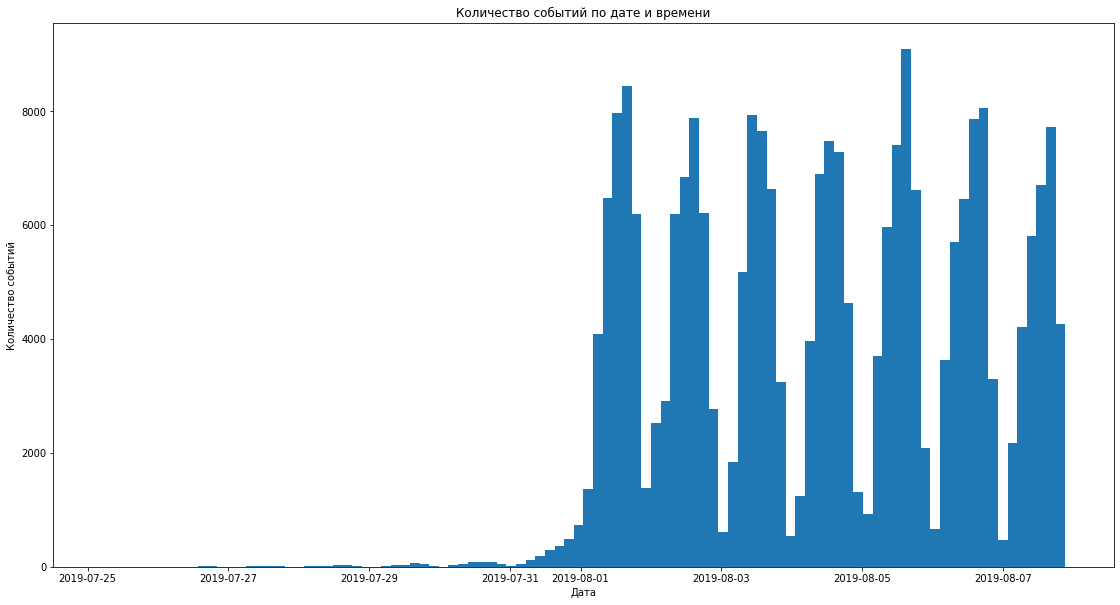

In [61]:
plt.figure(figsize=(19,10))
plt.hist(data['datetime'], bins=100)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Количество событий по дате и времени')

Видим, что данные неполные. Создадим новую таблицу с данными после 1 августа

In [62]:
data = data.query('date >= "2019-08-01"')

Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные

In [63]:
new_events_count = data['event'].count()
print('Общее количество событий в логе:', new_events_count)

new_users_count = data['user_id'].nunique()
print('Всего пользователей в логе:', new_users_count)

Общее количество событий в логе: 240887
Всего пользователей в логе: 7534


In [64]:
print('Потеряно событий:', events_count-new_events_count)
print('Потеряно событий:', users_count-new_users_count)

Потеряно событий: 2826
Потеряно событий: 17


**Проверим, что у нас есть пользователи из всех трёх экспериментальных групп**

In [65]:
groups = data.groupby('group').agg({'user_id':'nunique'}).reset_index()

In [66]:
groups

,group,user_id
0,246,2484
1,247,2513
2,248,2537


Пользователи есть во всех группах

**Итак:**

- Общее количество событий в логе: 243713

- Всего пользователей в логе: 7551

- В среднем событий на пользователя: 32.28

- Мы располагаем данными за период с 25 июля 2019 по 07 августа 2019, полными данными - с 1 по 7 августа 2019

# Изучение воронки событий

**Посмотрим, какие события есть в логах и как часто они встречаются**

In [67]:
data.groupby('event').agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False)

,event,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Чаще всего встречается MainScreenAppear, реже всего - Tutorial	

**Посчитаем, сколько пользователей совершали каждое из этих событий**

In [68]:
users_for_event = data.groupby('event').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
users_for_event

,event,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


**Посчитаем долю пользователей, которые хоть раз совершали событие**

In [69]:
users_for_event['share'] = ((users_for_event['user_id'] / data['user_id'].nunique() * 100).round())
users_for_event

,event,user_id,share
1,MainScreenAppear,7419,98.0
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


Видно, что событие MainScreenAppear	совершало 98% пользователей, в то время как Tutorial - всего 11%

**Определим порядок, в котором происходят события**

1. Главный экран
2. Экран предложений
3. Корзина
4. Экран оплаты
5. Туториал

Можем исключить туториал, так как до него доходит очень маленькая доля пользователей

**Посчитаем, какая доля пользователей проходит на следующий шаг воронки**

In [70]:
users_for_event_t = users_for_event.query('event != "Tutorial"')
fig = go.Figure(go.Funnel(y=users_for_event_t['event'], x=users_for_event_t['user_id']))
fig.update_layout(title='Воронка событий, которые совершают пользователи')
fig.show()

Проанализировав воронку, можем сделать выводы, что 61.9% пользователей переходят с главного экрана в каталог, 81.3% из каталога на экран оплаты и 94.8% совершают оплату. 

Больше всего пользователей "отпадают" на переходе из главного экрана в каталог

От первого события до оплаты доходит 47.7% пользователей

**Итак, в ходе изучения воронки событий было выявлено, что в логах присутствует 5 событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. Чаще всего присутствует событие MainScreenAppear, реже - Tutorial. Что касается доли пользователей на каждом шаге воронки, 61.9% пользователей переходят с главного экрана в каталог, 81.3% из каталога на экран оплаты и 94.8% совершают оплату. От первого события до оплаты доходит 47.7% пользователей**

# Изучение результатов эксперимента

Посчитаем сколько пользователей в каждой экспериментальной группе

In [71]:
data.groupby('group').agg({'user_id':'nunique'}).reset_index()

,group,user_id
0,246,2484
1,247,2513
2,248,2537


**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247**

Гипотезы:

- Нулевая: не существует статистически значимой разницы между долями;

- Альтернативная: между долями есть статистически значимая разница.

In [72]:
test = data.pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique').reset_index().query('event != "Tutorial"')
test['total'] = test[246]+test[247]+test[248]
test = test.sort_values(by='total', ascending=False)
test

group,event,246,247,248,total
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
0,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539


**Проведем z-тест**

In [73]:
def z_test(array, trials, column1, column2):
    for i in range(0, 4):
        successes = np.array([array.loc[i, column1], array.loc[i, column2]])     
        
        p1 = successes[0]/trials[0]       
        
        p2 = successes[1]/trials[1]       
        
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])       
        
        difference = p1 - p2       
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))      
        
        distr = st.norm(0, 1)        
        p_value = (1 - distr.cdf(abs(z_value))) * 2  
      
        alpha = 0.05 
        print('{} p-значение: {}'.format(test['event'][i], p_value))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')
            
            
trials = np.array([groups.loc[0, 'user_id'], groups.loc[1, 'user_id']])
z_test(test, trials, 246, 247) 

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Можем сделать вывод, что нет оснований считать доли разными при уровне статистической значимости, равной 5%

**Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие.**

In [74]:
test

group,event,246,247,248,total
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
0,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539


Самое популярное событие - MainScreenAppear

Найдем долю пользователей, совершивших это событие

In [75]:
main_share = data.query('event == "MainScreenAppear"').groupby('group').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
main_share['share'] = main_share['user_id']/data['user_id'].nunique() * 100
main_share

,user_id,share
group,,
248,2493,33.089992
247,2476,32.864348
246,2450,32.519246


**Проверим, будет ли отличие между группами статистически достоверным**

In [76]:
#сравним группы 246 и 248
trials = np.array([groups.loc[0, 'user_id'], groups.loc[2, 'user_id']])
z_test(test, trials, 246, 248) 

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Можем сделать вывод, что между группой 246 (контрольной) и 248 (экспериментальной) статистически значимой разницы нет

In [77]:
#сравним группы 247 и 248
trials = np.array([groups.loc[1, 'user_id'], groups.loc[2, 'user_id']])
z_test(test, trials, 246, 248)  

CartScreenAppear p-значение: 0.17793756017873896
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.05661336589860122
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.46038693051414503
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.3927720688492329
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Можем сделать вывод, что между группой 247 (контрольной) и 248 (экспериментальной) статистически значимой разницы нет

**Сравним объединённые контрольные группы**

In [78]:
test['cont'] = test[246] + test[247]
test

group,event,246,247,248,total,cont
1,MainScreenAppear,2450,2476,2493,7419,4926
2,OffersScreenAppear,1542,1520,1531,4593,3062
0,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358


In [79]:
mer = {'group':'cont', 'user_id': 2484+2513}

groups = groups.append(mer, ignore_index=True)
groups

,group,user_id
0,246,2484
1,247,2513
2,248,2537
3,cont,4997


In [80]:
trials = np.array([groups.loc[3, 'user_id'], groups.loc[2, 'user_id']])
z_test(test, trials, 'cont', 248)

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Вывод по итогам теста: между объединенными контрольными группами 246 и 247 и экспериментальной 248 статистически значимой разницы нет

# Выбор уровня статистической значимости

Общее количество проведенных проверок: 16

Выбранный уровент значимости 5%


**Повторно проверим гипотезы с уровнем статистической значимости в 1%**

In [81]:
def z_test(array, trials, column1, column2):
    for i in range(0, 4):
        successes = np.array([array.loc[i, column1], array.loc[i, column2]])     
        p1 = successes[0]/trials[0]       
        p2 = successes[1]/trials[1]       
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])       
        difference = p1 - p2       
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))      
        distr = st.norm(0, 1)        
        p_value = (1 - distr.cdf(abs(z_value))) * 2  
        alpha = 0.01 
        print('{} p-значение: {}'.format(test['event'][i], p_value))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')
            
            
trials = np.array([groups.loc[0, 'user_id'], groups.loc[1, 'user_id']])
z_test(test, trials, 246, 247)

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [82]:
trials = np.array([groups.loc[0, 'user_id'], groups.loc[2, 'user_id']])
z_test(test, trials, 246, 248)

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [83]:
trials = np.array([groups.loc[1, 'user_id'], groups.loc[2, 'user_id']])
z_test(test, trials, 247, 248)

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [84]:
trials = np.array([groups.loc[3, 'user_id'], groups.loc[2, 'user_id']])
z_test(test, trials, 'cont', 248) 

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Результат проверки с уровнем статистической значимости 1% подтвердил результаты проверки с уровнем статистической значимости в 5%, а значит изменение шрифта никак не влияет на поведение пользователей

# Вывод

На каждом этапе исследования выявлено следующее:

**Изучение и проверка данных**
- Общее количество событий в логе: 243713
- Всего пользователей в логе: 7551
- В среднем событий на пользователя: 32.28
- располагаем полными данными с 1 по 7 августа 2019

**Изучение воронки событий**
- Всего событий 5. Чаще всего встречается MainScreenAppear, реже всего - Tutorial. Событие MainScreenAppear совершало 98% пользователей, в то время как Tutorial - всего 11%
- Порядок событий: Главный экран -> Экран предложений -> Корзина -> Экран оплаты -> Туториал
- Больше всего пользователей "отпадают" на переходе из главного экрана в каталог
- От первого события до оплаты доходит 47.7% пользователей

**Изучение результатов эксперимента**
- в результате А/А эксперимента было выявлено, что между выборками 246 и 247 разница отсутствует

- <span style="color:blue">результат А/А/В эксперимента показал, что изменение шрифтов никак не влияет на поведение пользователей</span>